In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML

# Markov Chain Monte Carlo

```{margin}
This lecture continues to draw on [these lecture notes](https://personal.math.ubc.ca/~holmescerfon/teaching.html#asanotes), in particular Chapter 3.
```

Now, we will start working our way back to Bayesian statistics.

Recall the strategy we have been using to construct posterior distributions -- the __grid__ approach.

<center>
    
<img src="images/Grid-Bayesian-Update.jpg" width="650px">
    
</center>

This approach works well if we have only a few parameters: 1 or 2 or maybe 3.  But if we have more than three parameters, the size of the grid explodes.

Loosely speaking, the size of the grid is exponential in the number of parameters in our posterior.  So the grid approach can become infeasible for problems with large numbers of parameters.

The solution we will explore today will be to __not__ construct the whole posterior distribution.   Instead, we will find a way to __sample__ the posterior without actually constructing it!

The approach we will use is _Markov Chain Monte Carlo (MCMC)_. 

MCMC is a computer–driven sampling method for obtaining information about distributions. It allows one to characterize a distribution without knowing all of the distribution’s mathematical properties by randomly sampling values out of the distribution.

As the name suggests, MCMC combines two techniques that we are already familiar with: Monte Carlo simulations and Markov chains.

In particular, it utilizes the accept-reject method but improves its efficiency by enforcing the dependence of the new observation (or sample) on the current one. This improvement comes directly from the Markov property of the Markov chains.

Let us consider a simple example as an introduction to MCMC.

#### Predicting Average Test Score

Imagine a lecturer wants to estimate the average test score of students. While the exact average is unknown, the lecturer knows that the scores are normally distributed with a standard deviation of 15. So far, the lecturer has one observed test score: 100.

In Bayesian statistics, we want to update our beliefs about the average score based on this observation. MCMC can help us sample from the posterior distribution, which represents our updated beliefs about the average score after considering the observed data.

Here’s how MCMC works in this scenario:

1.  __Start with a Guess:__ Begin with an initial guess for the average score, say 110. This guess represents our prior belief about the average before seeing the data.

2. __Make a Proposal:__ Create a new guess by adding some random noise to the last guess. For example, if we add a random value from a normal distribution with a mean of 0 and a standard deviation of 5, we might get a new guess of 108.

3. __Evaluate the Proposal:__ Compare how likely the new guess (108) is given the observed score of 100. This involves calculating the likelihood of the data under both the new guess and the previous guess using the normal distribution centered around the observed score.

4. __Accept or Reject:__ <br>
If the new guess (108) is more likely than the old guess (110), accept it.

If it’s less likely, then randomly choose to accept or
reject the new proposal, based on a probability that reflects how likely each guess is.


5. __Repeat:__ If the new guess is accepted, it becomes the next sample. If not, we keep the old sample. This process continues, generating a chain of samples.

6. __Stop When Ready:__ Continue this process until you have enough samples to make a good estimate of the average score.


### Sampling a Steady-State

In the above example, each sample or observation (i.e., estimated average test score) is generated based on the previous sample. This means that the process moves from one sample to another based solely on the current sample. Letting samples be the states of a Markov chain, we clearly see that the process adheres to the Markov property.



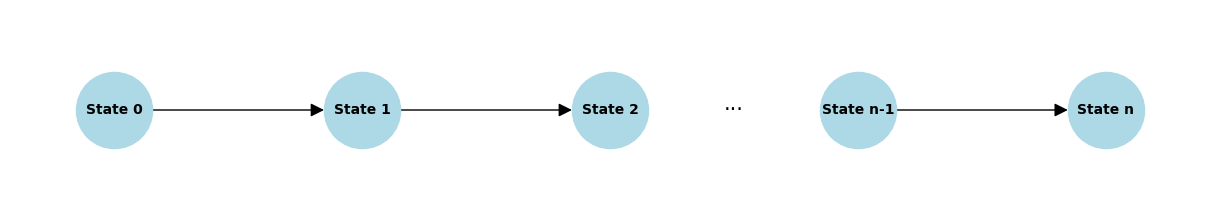

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

def create_markov_chain(n):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (states)
    states = [f'State {i}' for i in range(3)] + [f'State n-1', f'State n']
    G.add_nodes_from(states)

    # Add edges (transitions)
    edges = [(f'State {i}', f'State {i+1}') for i in range(2)]  # Transitions up to State 2
    edges.append((f'State n-1', f'State n'))  # Transition from State n-2 to State n-1
    G.add_edges_from(edges)

    # Define positions for a linear layout
    pos = {state: (i, 0) for i, state in enumerate(states)}
    
    # Draw the graph
    plt.figure(figsize=(12, 2))
    nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', font_size=10, font_weight='bold', arrowsize=20)
    
    # Add ellipsis for the skipped transition
    plt.text(2.5, 0, '...', fontsize=15, ha='center')
    
    plt.show()

# Example usage with n states
n = 6
create_markov_chain(n)

The initial guess for the mean test score is 110. This represents the starting state of the Markov chain. This sample is influenced by prior beliefs and may not reflect the true average based on the observed data. 

Over time, as more samples are generated, the distribution of these samples will begin to reflect the true posterior distribution of the population mean. By construction, after sufficient iterations, the samples will converge to a __steady state__, where the probabilities of the mean values stabilize around the true mean. 

A similar situation occurs when we consider a distribution that is too high-dimensional to use a grid method to construct it. For concreteness, let's say it is a posterior distribution over 5 parameters.

In this case, each state of the chain would be a particular set of values for each of the parameters. Let's say that the parameters are $\theta = (\theta_1, \theta_2, \theta_3, \theta_4, \theta_5).$  Then a particular state of the chain would be some choice of values for each of the $\theta_i$s.  

For example, one state of the Markov chain could be $(0.3, 10, 3.4, 11.1, -8)$.  Clearly the set of all such states is incredibly large, because there are so many combinations of parameter settings.

The approach would be again to costruct a certain steady-state distibution over the states of the Markov chain, a distribution that is equal to the posterior distribution over $\theta$ that we want to obtain.  We can then get a sample of that distribution by running the Markov chain to steady-state and observing what state it is in.

The question that we need to answer now is "How do we construct such a Markov chain"?

The key idea is to set the transition probabilities of the Markov chain so as to ensure that the steady-state of the chain will be the distribution we want to sample (i.e., the posteror distribution). This can be done using __detailed balance__.   

Then we let the Markov chain run "long enough" that it is in steady-state.  At that point, we can use an observation of the state of the chain as a sample of the target distribution.  That's it!

## The Metropolis-Hastings Algorithm

```{margin}
For background on this algorithm, see Nick Hingham’s [blog post](https://nickhigham.wordpress.com/2016/03/29/the-top-10-algorithms-in-applied-mathematics/)
```

The most common algorithm for MCMC is the __Metropolis-Hastings algorithm__, an algorithm that has been named one of the top ten most influential algorithms of the 20th century!

### The Main Steps of Metropolis-Hastings Algorithm

- Pick an **initial state** (e.g., some setting for our parameters).
- From that state we generate a new state, called the **proposal state** (e.g., a different setting for our parameters).
- We then transition to the proposal state according to a **transition probability** that creates detailed balance for the **target distribution** we want to sample. 
- After repeating this long enough, we are in steady-state, and the particular state we are in is a sample of the target distribution.


### Example

Let's say we're looking at the Euro coin problem one more time where we saw 140 heads in 250 spins of the coin. Like before, our goal is to eventually find the posterior distribition that is the Beta distribution that peaks at $p=0.56$ (we found that we could easily calculate this posterior before by looking at likelihoods of all values of $p$, but listing all options  like this wouldn't be feasible with more parameters to estimate).    

That means our **target distribution** is a Beta distribution that peaks at $p=0.56$. Remember, the target distribution is unkown, but we can calculate the likelihood of our data at any value of $p$.

We can pick an **initial state** uniformly at random. Let's say we pick $p=0.2$.

We now generate a **proposal state** uniformly at random (of course, this doesn't need to be uniformly at random).

Let's say we pick $p = 0.3$.

We then need to transition to that state with some **transition probability**. We can do that by calculating the likelihoods for our data of $p=0.3$ and $p=0.2$.

Those likelihoods are given by Binomial distributions with $p=0.2$ and $0.3$ with 140 heads in 250 spins of the coin, which are 4.609531e-36 and 8.656031e-18, respectively.

So let's set the transition probability from our initial state to the proposal state as the $\min(1, \frac{8.656031e-18}{4.609531e-36})=1$ (we need to make sure the probability isn't greater than 1. The return probability will similarly be  $\min(1, \frac{4.609531e-36}{8.656031e-18})=5.325225e-19$. Since the transition probability is 1, we move to the proposal state.

Now we have the following Markov chain:

<center>

<img src="images/Euro_Coin_Markov.png" alt="Figure" width="450px">
    
</center>


And so far have visited the states $p=0.2$ and $p=0.3$ once each. We can already see at this point that we are going to visit the state $p=0.3$ much more often than $p=0.2$.

It turns out that this Markov chain is in detailed balance and detailed balance means a steady state.

If we keep this process up, in the long term we will visit each state proportionally to the target distribution! Or put another way, the steady state over enough nodes will be the target distribution.

### Generating Good Candidates

Now, the previous algorithm works, but it has a drawback.   By generating proposal states uniformly at random, we probably will generate many low-probability proposals to which we would not transition very often.

So what we need is to be able to generate "nearby" proposal states, so that if we are in a high-probability state, we will likely jump to another high-probability state.

We can think of the proposal generation as another random process $H$, where $H_{ij}$ is the probability of generating proposal state $i$ when we are in current state $j.$

__Overview of Complete Metropolis-Hastings Algorithm__

1. **Target Distribution:** Let $\pi$ be the target probability distribution over states $S$, and $\pi'$ be a function proportional to $\pi$.

2. **Markov Chain Construction:** The algorithm creates a sequence of states $X_0, X_1, \ldots$ that eventually follows the distribution $\pi$. 

3. **Generating the Next State:**
   - Start with the current state $X_n = j$.
   - **Propose a New State:** Choose a candidate state $Y$ based on the transition probabilities from state $j$ (given by the $j$th column of matrix $H$).
   - **Acceptance Probability:** Calculate the acceptance probability:

   $$
   a_{ij} = \min\left(1, \frac{\pi'_i H_{ji}}{\pi'_j H_{ij}}\right)
   $$

   - **Accept or Reject:** 
     - If a random number $U$ (uniformly chosen between 0 and 1) is less than $a_{ij}$, accept the new state $Y$ (set $X_{n+1} = Y$).
     - Otherwise, keep the current state (set $X_{n+1} = X_n$).

Let's confirm that this works. We are going to show that the Markov chain constructed by the Metropolis-Hastings algorithm has the steady-state distribution $\pi$ that is proportional to $\pi'$.

Suppose that $\pi'_j H_{ij} > \pi'_i H_{ji}.$

Then $P_{ij} = H_{ij} \min\left(1, \frac{\pi'_i H_{ji}}{\pi'_j H_{ij}}\right) = \frac{\pi'_i}{\pi'_j} H_{ji} = \frac{\pi_i}{\pi_j} H_{ji}$.

And $P_{ji} = H_{ji} \min\left(1, \frac{\pi'_j H_{ij}}{\pi'_i H_{ji}}\right) = H_{ji}.$

So

$$ \pi_j P_{ij} = \pi_j \frac{\pi_i}{\pi_j} H_{ji} = \pi_i H_{ji} = \pi_i P_{ji}. $$

A similar calculation holds if $\pi'_j H_{ij} \leq \pi'_i H_{ji}.$  Therefore the chain satisfies detailed balance with respect to $\pi$, so $\pi$ is the stationary distribution.

__Example.__ Consider sampling a posterior distribution using MCMC.   

Assume the target desired posterior is proportional to the uniform distribution on $[0, 2]$ and 0 elsewhere: <br>

$$p_T(x) = 1/2 \;\;\;\text{for}\;\;\; 0\leq x < 2.$$ $$p_T(x) = 0 \;\;\;\text{for}\;\;\;  x < 0 , x \geq 2.$$

Assume the candidate generating distribution is uniform on $[0, 4]$: <br> 

$$p_C(x) = 1/4 \;\;\;\text{for}\;\;\; 0\leq x < 4.$$

Recall that the Metropolis-Hastings rule is to accept a proposed transition from $j$ to $i$ with probability: $a_{ij} = \min \left(1, \frac{\pi'_i H_{ji}}{\pi'_j H_{ij}}\right) $

Consider a transition from $x = 3$ to $x = 1/2$.  What is the probability this transition will be accepted?


$$a_{1/2,3} = \min \left(1, \frac{1/2 * 1/4}{0*1/4}\right) = 1$$


Consider a transition from $x = 1/2$ to $x = 1$.  What is the probability this transition will be accepted?


$$a_{1,1/2} = \min \left(1, \frac{1/2 * 1/4}{1/2*1/4}\right) = 1$$


__Example.__ Consider the target distribution which is proportional to the mixture of two normal distributions: $(1/2)N(-2,1) + (1/2)N(2,1).$

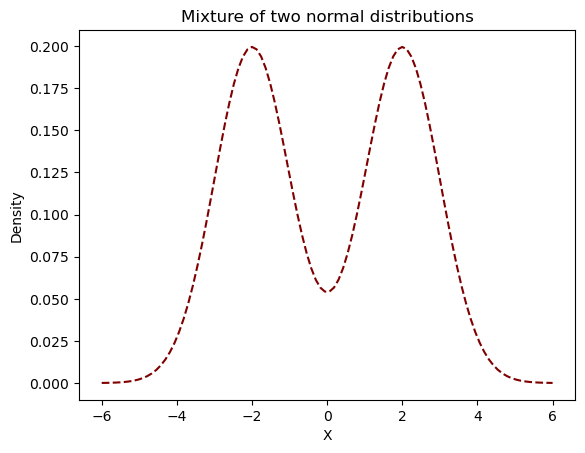

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
dist1 = norm(-2, 1)
dist2 = norm(2, 1)
X = lambda x: 0.5*dist1.pdf(x) + 0.5*dist2.pdf(x)
x_range = np.linspace(-6, 6, 100)
plt.plot(x_range, X(x_range),color='maroon', linestyle='--')
plt.xlabel('X')
plt.ylabel('Density')
plt.title('Mixture of two normal distributions')
plt.show()

This time instead of picking candidates uniformly at random we will select them using a normal distribution around the current state with a standard deviation of 1. 

Consider a transition from $x=3$ to $x=1/2$. What is the probability this transition will be accepted?


$$a_{1/2,3} = \min \left(1, \frac{\pi'_{1/2} H_{3,1/2}}{\pi'_3 H_{1/2,3}}\right) = \min \left(1, \frac{p(1/2 ; (1/2)N(-2,1) + (1/2)N(2,1)) * p(3 ; N(1/2,1))}{p(3 ; (1/2)N(-2,1) + (1/2)N(2,1)) * p(1/2 ; N(3,1))}\right)$$


However, the normal distribution is symmetric, meaning $p(1/2 ; N(3,1)) = p(3 ; N(1/2,1)$ so we can actually just cancel those terms.

So all we need to do is calculate the likelihoods of 1/2 and 3 in our target distribution:

$$ p(1/2 ; (1/2)N(-2,1) + (1/2)N(2,1)) = 0.07 $$

$$ p(3 ; (1/2)N(-2,1) + (1/2)N(2,1)) = 0.12 $$


$$a_{1/2,3} = \min \left(1, \frac{0.07}{0.12}\right) = 0.58$$


## MCMC Considerations

There are a number of considerations for using MCMC in practice.

First, while you are free to choose any proposal matrix $H$, some choices will work better than others.  Coosing a good proposal matrix is an art.  If your proposals are too close to your current point, then you accept almost every move, but it takes a long time to explore the whole space.  If your proposals are too far from your current point, you reject almost all moves, which also slows convergence.

Next, the chain may take some time from its starting point before it actually reaches the stationary distribution.  The length of initial transient data is referred to as the _burn-in_ time.  Generally you want to throw out an initial number of data steps, and then make sure the total run is much longer than what you threw out.

How long does it take the chain to reach steady-state?  If we could construct the entire transition matrix we could estimate this using the eigenvalues of the matrix.  However we almost never have that matrix, so one must determine whether the chain has converged through empirical measures.  One measure is simply to plot the statistic you are estimating as a function of time, and observe when it has settled down and doesn't change much.

There are more good considerations to take into account [here](https://personal.math.ubc.ca/~holmescerfon/teaching.html#asanotes) (Chapter 3).

## MCMC Example

```{margin}
This example is adapted from [MCMC Intuition for Everyone](https://towardsdatascience.com/mcmc-intuition-for-everyone-5ae79fff22b1) by Rahul Agarwal. 
```

Consider the Belgian Euro problem again this time with all that math in mind. Remeber, we observe a set of coin tosses and want to estimate the distribution of $p$, the probability of heads. 

Our data consists of $x$ heads and $n-x$ tails. 

If we assume a uniform prior, the target posterior is, as we know, 

$$ \text{Posterior}_x \propto \theta^x (1-\theta)^{n-x}. $$

An important point is that to use MCMC, we don't need to worry about the normalizing constant on the posterior. This is because the normalizing constant will appear in both the numerator and denominator in the expression

$$ a_{ij} = \min\left(1, \frac{\pi'_i H_{ji}}{\pi'_j H_{ij}}\right) $$

and so will cancel out.  This is very helpful!

Furthermore, we will generate candidates uniformly from the range $[0, 1]$ for simplicity.

Thus our acceptance criterion is simply:

$$ a_{ij} = \min\left(1, \frac{\theta_i^x(1-\theta_i)^{n-x}}{\theta_j^x(1-\theta_j)^{n-x}}\right). $$

Let's translate what we just did into code:

In [100]:
import random

# Our posterior; ignoring the normalizing constant
def posterior(theta, x, n):
    return (theta**x)*((1 - theta)**(n-x))

# Return true with probability p
def random_coin(p):
    unif = random.uniform(0,1)
    if unif < p:
        return True
    else:
        return False

# Run the Markov chain for coin flipping
def mcmc(n_steps, x, n):
    states = []
    cur = random.uniform(0, 1)
    for i in range(n_steps):
        states.append(cur)
        next = random.uniform(0, 1)
        # Calculate the acceptance probability
        ap = min(1, posterior(next, x, n) / posterior(cur, x, n)) 
        if random_coin(ap):
            cur = next
    return states 

Now let's run MCMC for 2000 steps:

In [134]:
random.seed(2)
samples = mcmc(2000, 100, 250)

and let's look at the properties of the samples.  Recall that the early steps of the Markov chain may not have reached steady state, so let's look at the mean over time:
    

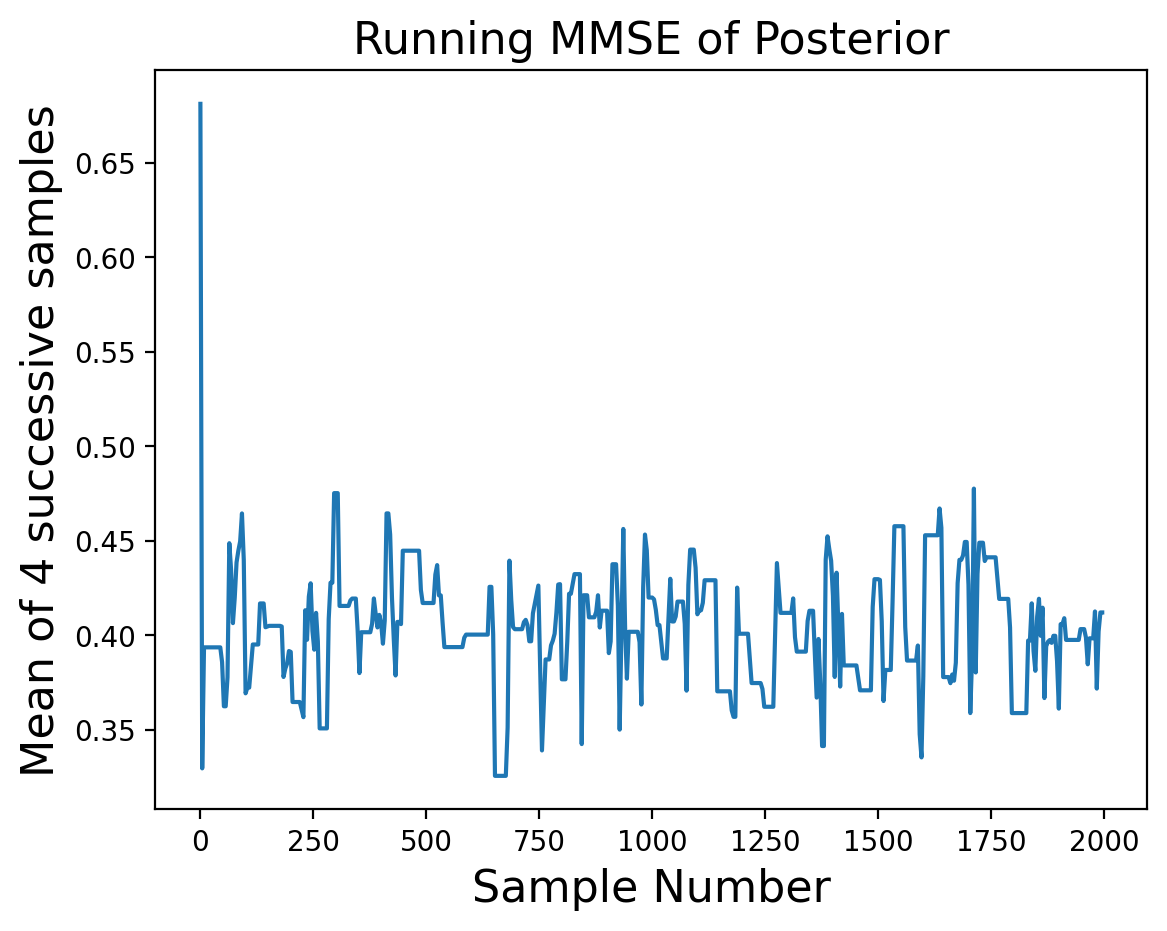

In [135]:
def group_means(x, N):
    '''return means of each N items (nonoverlapping windows)'''
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return ((cumsum[N:] - cumsum[:-N]) / float(N))[::N]

plt.plot(range(0, 2000, 4), group_means(samples, 4))
plt.xlabel('Sample Number', size = 16)
plt.ylabel('Mean of 4 successive samples', size = 16)
plt.title('Running MMSE of Posterior', size = 16);

It looks like the first dozen or so samples are not yet at steady-state, so let's eliminate them:

In [136]:
good_samples = samples[12:]

And let's look at the distribution of samples we've obtained from MCMC:

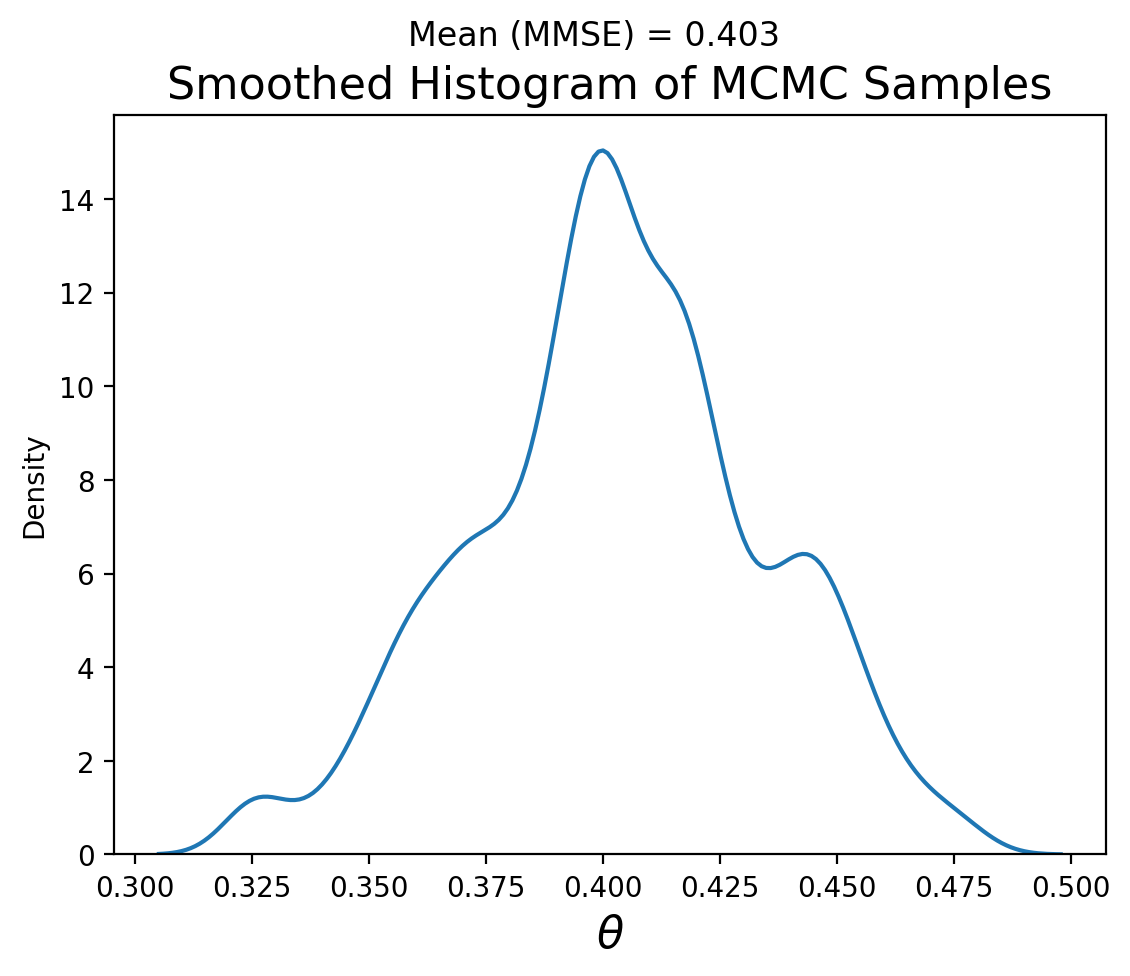

In [137]:
sns.kdeplot(good_samples)
plt.title('Smoothed Histogram of MCMC Samples', size = 16)
plt.suptitle(f'Mean (MMSE) = {np.mean(good_samples):0.3f}')
plt.xlabel(r'$\theta$', size = 16);

Note that the MMSE of $\theta$ is very close to 0.4, which is what we expect (100/250) and the distribution looks remniscent of our grid search result:

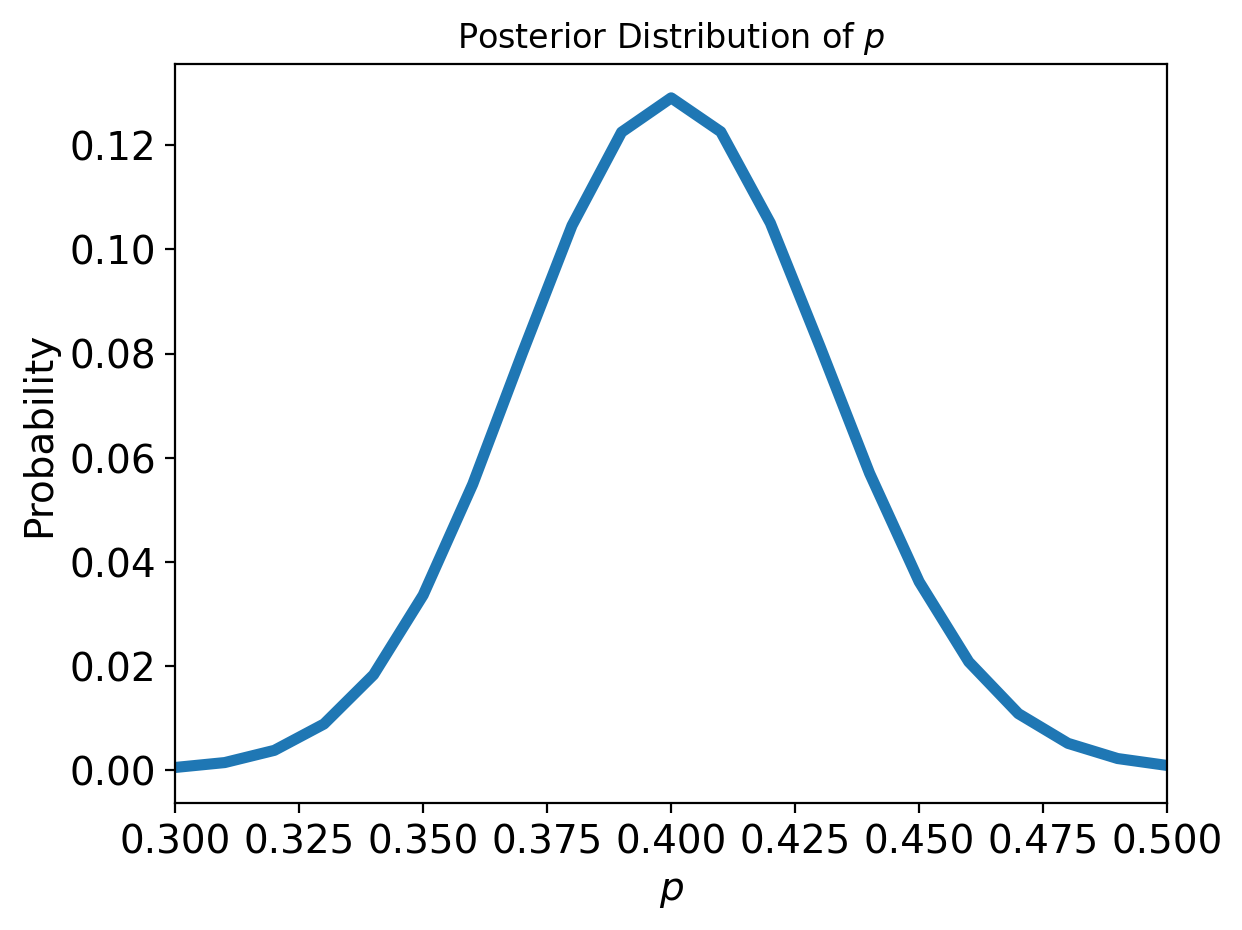

In [8]:
from scipy.stats import randint
from scipy.stats import binom

# our usual update function
def update(distribution, likelihood):
    distribution['probs'] = distribution['probs'] * likelihood
    prob_data = distribution['probs'].sum()
    distribution['probs'] = distribution['probs'] / prob_data
    return distribution

# start with uniform prior
p_dist = pd.DataFrame(index = np.arange(101)/100)
p_dist['probs'] = randint(0, 101).pmf(np.arange(101)) 

# compute whole-data likelihoods
likelihood = [binom.pmf(100, 250, p) for p in p_dist.index]

update(p_dist, likelihood);

p_dist.plot(lw = 4, legend = False, title = 'Posterior Distribution of $p$', fontsize = 14)
plt.xlabel('$p$', size = 14)
plt.ylabel('Probability', size = 14);
plt.xlim(.3,.5);